Workflow and algorithm inspiration taken from:
Chen, H., Wang, N., Du, X., Mei, K., Zhou, Y., & Cai, G. (2023). Classification prediction of breast cancer based on machine learning. Computational Intelligence and Neuroscience, 2023, 1–9. https://doi.org/10.1155/2023/6530719

# Import libraries

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from collections import Counter

# Load the data

In [ ]:
train_data = np.genfromtxt('Train_Set.csv', delimiter=',', dtype=str, skip_header=1)
test_data = np.genfromtxt('Test_Set.csv', delimiter=',', dtype=str, skip_header=1)

def convert_labels(data):
    labels = data[:, -1]
    labels = np.where(labels == 'healthy', 0, 1)
    features = data[:, :-1].astype(float)
    return features, labels

X_train, y_train = convert_labels(train_data)
X_test, y_test = convert_labels(test_data)

# Check for the imbalance data


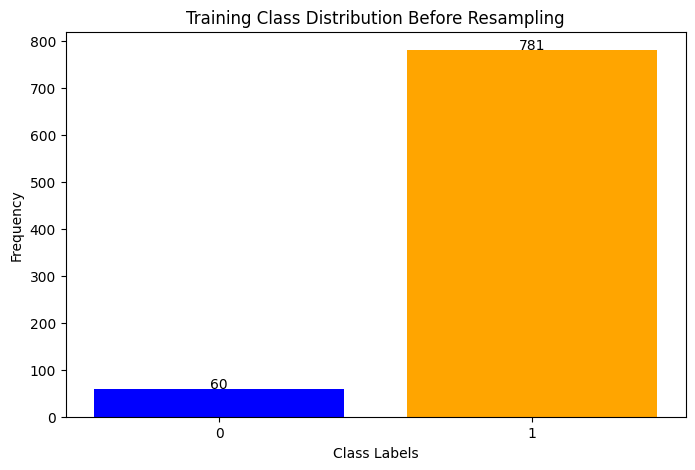

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate the class distribution
class_counts = Counter(y_train)

# Extract class labels and their corresponding counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a list of colors to differentiate the classes
colors = ['blue', 'orange']  # Add more colors if needed

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, counts, color=colors[:len(classes)])
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Training Class Distribution Before Resampling')
plt.xticks(classes)  # Set x-ticks to the class labels

# Add class counts on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,  # Position the text slightly below the top
             str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


# Preprocess the data

### Feature Scalling


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature Reduction: PCA

In [ ]:
pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(f"Number of components retained by PCA: {X_train.shape[1]}")

Number of components retained by PCA: 20


### Handling Class imbalance


You only need to run one of the code snippets in this section.


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='minority', random_state=0, n_neighbors=5)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [ ]:

from collections import Counter
from imblearn.over_sampling import SMOTE

print("Class distribution before oversampling:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after oversampling:", Counter(y_train))

Class distribution before oversampling: Counter({1: 781, 0: 60})
Class distribution after oversampling: Counter({0: 781, 1: 781})


In [ ]:
from imblearn.under_sampling import NearMiss

print("Class distribution before oversampling:", Counter(y_train))
nearmiss = NearMiss(version=1)
X_train, y_train = nearmiss.fit_resample(X_train, y_train)
print("Class distribution after oversampling:", Counter(y_train))

Class distribution before oversampling: Counter({0: 802, 1: 802})
Class distribution after oversampling: Counter({0: 802, 1: 802})


We do not want to use NearMiss because it reduces our training data to only 120 samples, which is much smaller than our test data size of 400, potentially causing underfitting.


In [ ]:
from imblearn.under_sampling import OneSidedSelection
print("Class distribution before oversampling:", Counter(y_train))
oss = OneSidedSelection(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=1,
    n_jobs=4
)
X_train, y_train = oss.fit_resample(X_train, y_train)
print("Class distribution after oversampling:", Counter(y_train))

Class distribution before oversampling: Counter({0: 802, 1: 802})
Class distribution after oversampling: Counter({0: 802, 1: 753})


OSS did not effectively balance our data; it only reduced the majority class from 781 to 762, which is insufficient for addressing the class imbalance.

# Modelling


### Split Data to Train and Validation


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



### Build Models and Test Against Validation Data


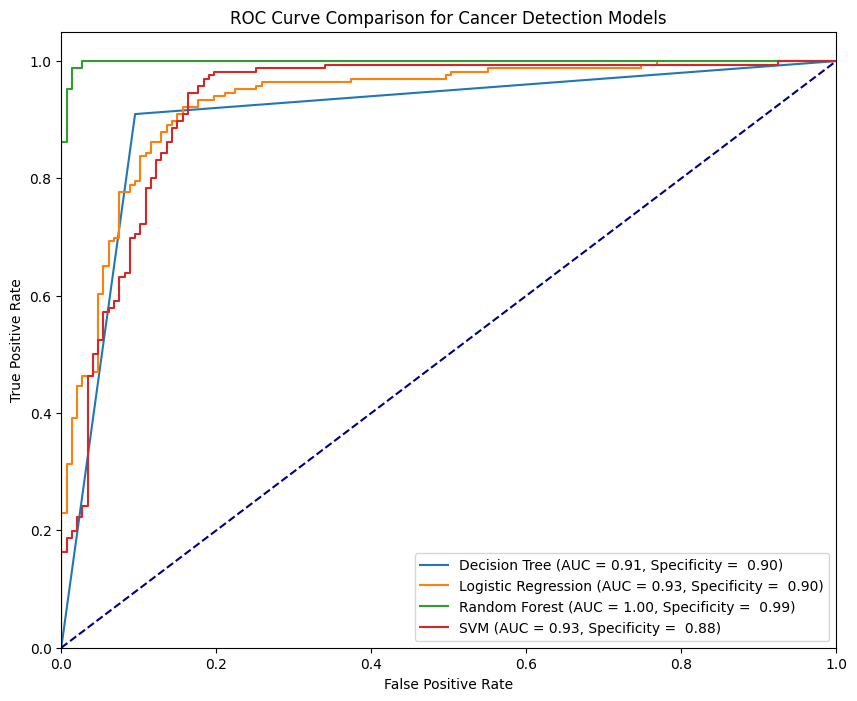

In [ ]:
#Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
}

#Create a list to store results
results = []

#Train each model and calculate metrics, ROC curves
plt.figure(figsize=(10, 8))  # ROC curve figure

for model_name, model in models.items():
    model.fit(train_X, train_y)  # Train the model

    y_pred = model.predict(valid_X)  # Predict on the test set

    # Get the confusion matrix (TN, FP, FN, TP)
    tn, fp, fn, tp = confusion_matrix(valid_y, y_pred).ravel()

     # Step 6: Compute ROC curve and ROC area for each model
    y_proba = model.predict_proba(valid_X)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(valid_y, y_proba)  # ROC curve
    roc_auc = auc(fpr, tpr)  # AUC score
    specificity = tn / (tn + fp)

    # Store the results in a dictionary
    results.append({
        'Model': model_name,
        'Specificity': tn / (tn + fp),
        'roc_auc': roc_auc
    })

    # Plot the ROC curve for each model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f}, Specificity = {specificity: .2f})')

#Convert the results list to a DataFrame using pd.concat()
results_df = pd.concat([pd.DataFrame([res]) for res in results], ignore_index=True)

#ROC curve plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Cancer Detection Models')
plt.legend(loc="lower right")
plt.show()


# Evaluation


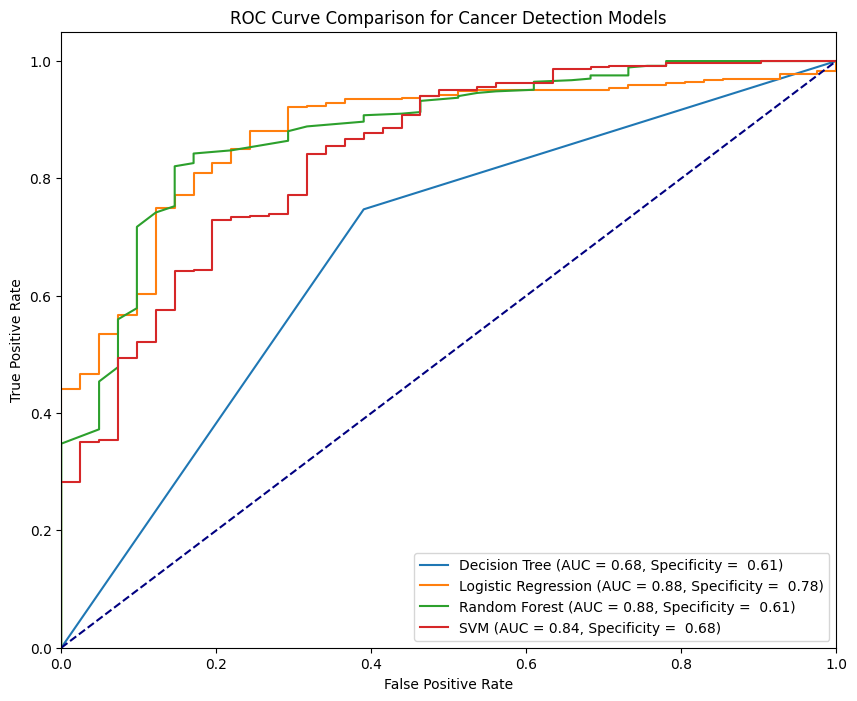

In [ ]:
#Create a list to store results
results = []

#Train each model and calculate metrics, ROC curves
plt.figure(figsize=(10, 8))  # ROC curve figure

for model_name, model in models.items():
    model.fit(train_X, train_y)  # Train the model

    y_pred = model.predict(X_test)  # Predict on the test set

    # Get the confusion matrix (TN, FP, FN, TP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Compute ROC curve and ROC area for each model
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)  # ROC curve
    roc_auc = auc(fpr, tpr)  # AUC score
    specificity = tn / (tn + fp)

    # Store the results in a dictionary
    results.append({
        'Model': model_name,
        'Specificity': tn / (tn + fp),
        'roc_auc': roc_auc
    })

    # Plot the ROC curve for each model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f}, Specificity = {specificity: .2f})')

#Convert the results list to a DataFrame using pd.concat()
results_df = pd.concat([pd.DataFrame([res]) for res in results], ignore_index=True)

#ROC curve plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Cancer Detection Models')
plt.legend(loc="lower right")
plt.show()

